Name: Robert Kim\
Date: 06-09-2023\
Email: rkim@salk.edu\
generate_trials.m\
Description: Script to generate trials\

coverted from .m to .pynb by Holly Kular\
date: 02-15-2024

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [150]:
# add functions from other notebooks
%run fnc_generate_trials.ipynb
%run fnc_eval_model.ipynb

In [147]:
# MODIFY HERE
# what conditions were the RNNs trained on?
prob_split = '70_30' # the probability of stimulus 1 vs all
afc = '2' # number of alternatives
coh = 'hi' # coherence
feedback = False # interlayer feedback (true or false)

In [148]:
# Data Directory
data_dir = f"/Volumes/serenceslab/holly/RNN_Geo/data/rdk_{prob_split}_{afc}afc/feedforward_only/{coh}_coh"

# Get all the trained models (should be 40 .mat files)
mat_files = [f for f in os.listdir(data_dir) if f.endswith('.mat')]

# Choose one model as an example
model_path = os.path.join(data_dir, mat_files[1])

In [149]:
# **Testing task condition 
task_info = {}
task_info['trials'] = 100
task_info['trial_dur'] = 250  # trial duration (timesteps)
task_info['stim_on'] = 80
task_info['stim_dur'] = 50
task_info['num_stims'] = int(afc) # nAFC
if coh == 'hi': # hi_coh = 0.7 vs. lo_coh = 0.6
    task_info['coh'] = 0.7 
else:
    task_info['coh'] = 0.6
    
task_info['units'] = 200 # number of units
# NOTE: adjust pred and primary_prob to change the testing environement
# Ex. Evenly distributed 6-AFC => task_info.primary_prob = 1/6;
# Ex. pred=5 and primary_prob = 0.7 => stim "5" will be predominant (70% of the time)
task_info['pred'] = 1 # predominant stimulus is "1"
task_info['primary_prob'] = 0.70; # 70-30 split

In [151]:
# Store firing rates, outputs, and labels for each trials
fr1 = fr2 = fr3 = np.zeros((task_info['trials'], task_info['trial_dur'], task_info['units']))
outs = np.zeros((task_info['trials'], task_info['trial_dur']))
labs = np.zeros((task_info['trials'], 1))

for tri in range(0, task_info['trials']):
    # Generate trials
    u, lab = fnc_generate_trials('rdk', task_info)

    # Now test the trained model
    out, O = fnc_eval_model(model_path, u, feedback)

    outs[tri, :] = out['O']  # Store the output signal
    labs[tri] = lab
    
    fr1[tri, :, :] = out['R1']
    fr2[tri, :, :] = out['R2']
    fr3[tri, :, :] = out['R3']
print(f'done generating trials')

done generating trials


## -----------------------Exploratory section below-----------------------

In [152]:
# TODO:
# decoding over time - done
# plot weights - done?
# compare inhibitory and excitatory units - in progress
# decoding over time - done

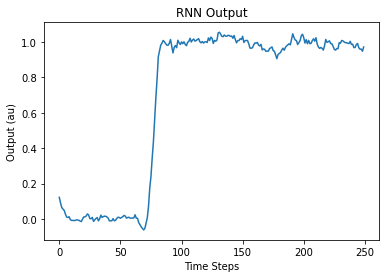

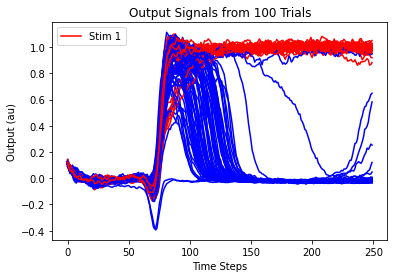

In [153]:
# Look at model output
plt.figure()
plt.xlabel('Time Steps')
plt.ylabel('Output (au)')
plt.title('RNN Output')
plt.plot(out['O'])
plt.show()

# Look at trials
idx = labs == 1
plt.figure()
first_else_encountered = False 
for i in range(outs.shape[0]):
    if idx[i]:
        plt.plot(outs[i, :], 'b')
    else:
        #plt.plot(outs[i, :], 'r', label='Stim 1' if i < 1 else '_nolegend_')
        if not first_else_encountered:
            plt.plot(outs[i, :], 'r', label='Stim 1')
            first_else_encountered = True  # Update flag
        else:
            plt.plot(outs[i, :], 'r', label='_nolegend_')
        
plt.xlabel('Time Steps')
plt.ylabel('Output (au)')
plt.title('Output Signals from 100 Trials')
plt.legend()
plt.show()

In [36]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.svm import SVC  
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification  

In [116]:
# Decode trials
# which layer do we want? 
layer = 1

# averge fr over this time window post stimulus
# this is unit of model time-steps
t_win = [ 200,-1 ]

# number of cv folds
n_cvs = 5 # performance goes up with fewer cvs? looked at 3

# store the accuracy
acc = np.full( ( n_cvs ), np.nan )

# penalties to eval
num_cgs = 30
Cs = np.logspace( -5,1,num_cgs )

# set up the grid
param_grid = { 'C': Cs, 'kernel': ['linear'] }

# define object - use a SVC that balances class weights (because they are biased, e.g. 70/30)
# note that can also specify cv folds here, but I'm doing it by hand below in a loop
grid = GridSearchCV( SVC(class_weight = 'balanced'),param_grid,refit=True,verbose=0 )

# get the data from the layer that we want
# this is a [trial x time step x unit] matrix
data_d = locals()[f'fr{layer}']


In [120]:
# avg over time window
#data_d = np.mean( data_d[ :,t_win[0]:t_win[1],: ], axis = 1 )

# get some info about structure of the data
tris = data_d.shape[0]             # number of trials
tri_ind = np.arange(0,tris)      # list from 0...tris
hold_out = int( tris / n_cvs )   # how many trials to hold out

decoding_acc = np.zeros((task_info['trial_dur'],))

for t_step in range(task_info['trial_dur']):
    
    data_slice = data_d[:, t_step, :]
    
    # loop over cvs and do classification
    for i in range(n_cvs):

        # trials to hold out as test set on this cv fold
        tst_ind = tri_ind[ i*hold_out : (i+1)*hold_out ]

        # index into the training data on this cv fold
        trn_ind = np.setdiff1d( tri_ind, tst_ind )

        # get the training data (X) and the training labels (y)
        # note that y is unbalanced unless prob is 50/50
        # todo: verify that SVC(class_weight = 'balanced')
        # is working as desired!
        # HK done: follows formula of n/ki
        X = data_slice[trn_ind,:]
        y = labs[trn_ind].flatten()

        # fit the model
        grid.fit( X,y )

        # progress report
        #print(f'CV: {i}, {grid.best_estimator_}')

        # get the test data (X) and the test labels (y)
        X_test = data_slice[tst_ind, :]
        y_test = labs[tst_ind]

        # predict!
        acc[ i ] = grid.score( X_test,y_test )

    decoding_acc[t_step] = np.mean(acc)
print(f'done decoding')

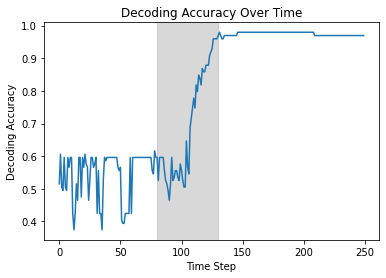

In [124]:
# Plot decoding accuracy over time
plt.figure()
plt.plot(range(task_info['trial_dur']), decoding_acc)
plt.xlabel('Time Step')
plt.ylabel('Decoding Accuracy')
plt.title('Decoding Accuracy Over Time')
plt.axvspan(task_info['stim_on'], task_info['stim_on']+task_info['stim_dur'], color = 'gray', alpha = 0.3)
plt.show()

In [66]:
# Look at what is inside the data file
data = loadmat(model_path)
data.keys() 

dict_keys(['__header__', '__version__', '__globals__', 'x1_0', 'r1_0', 'w1_0', 'x2_0', 'r2_0', 'w2_0', 'x3_0', 'r3_0', 'w3_0', 'w21_0', 'w32_0', 'taus_gaus1_0', 'taus_gaus2_0', 'taus_gaus3_0', 'w_in0', 'u', 'o', 'w1', 'w2', 'w3', 'w21', 'w32', 'x1', 'x2', 'x3', 'target', 'w_out', 'r1', 'm1', 'r2', 'm2', 'r3', 'm3', 'w21_m', 'w32_m', 'som_m', 'N1', 'N2', 'N3', 'exc1', 'inh1', 'exc2', 'inh2', 'exc3', 'inh3', 'w_in', 'b_out', 'som_N', 'losses', 'taus', 'eval_perf_mean', 'eval_loss_mean', 'eval_os', 'eval_labels', 'taus_gaus1', 'taus_gaus2', 'taus_gaus3', 'tr', 'activation'])

data['exc1'] # (200,1) 1s and 0s index of which units in layer 1 are excitatory? so multiply that with FR1 to get FR of excitatory

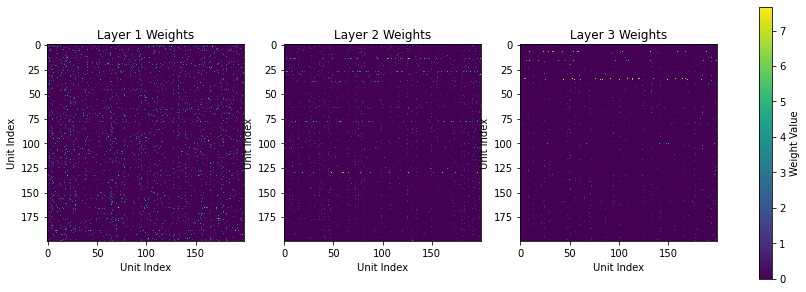

In [89]:
# Assuming data['w1'], data['w2'], and data['w3'] contain the weights arrays for the three layers
weights_layer1 = data['w1']
weights_layer2 = data['w2']
weights_layer3 = data['w3']

# Determine the overall min and max values of the weights arrays
min_val = min(weights_layer1.min(), weights_layer2.min(), weights_layer3.min())
max_val = max(weights_layer1.max(), weights_layer2.max(), weights_layer3.max())

# Create subplots for each layer
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot heatmap for layer 1
axes[0].imshow(weights_layer1, cmap='viridis', interpolation='nearest')
axes[0].set_title('Layer 1 Weights')
axes[0].set_xlabel('Unit Index')
axes[0].set_ylabel('Unit Index')
axes[0].set_aspect('equal')  # Set aspect ratio to be equal

# Plot heatmap for layer 2
axes[1].imshow(weights_layer2, cmap='viridis', interpolation='nearest')
axes[1].set_title('Layer 2 Weights')
axes[1].set_xlabel('Unit Index')
axes[1].set_ylabel('Unit Index')
axes[1].set_aspect('equal')  # Set aspect ratio to be equal

# Plot heatmap for layer 3
heatmap3 = axes[2].imshow(weights_layer3, cmap='viridis', interpolation='nearest', vmin=min_val, vmax=max_val)
axes[2].imshow(weights_layer3, cmap='viridis', interpolation='nearest')
axes[2].set_title('Layer 3 Weights')
axes[2].set_xlabel('Unit Index')
axes[2].set_ylabel('Unit Index')
axes[2].set_aspect('equal')  # Set aspect ratio to be equal

# Add colorbars
fig.colorbar(heatmap3, ax=axes.ravel().tolist(), label='Weight Value')

plt.show()

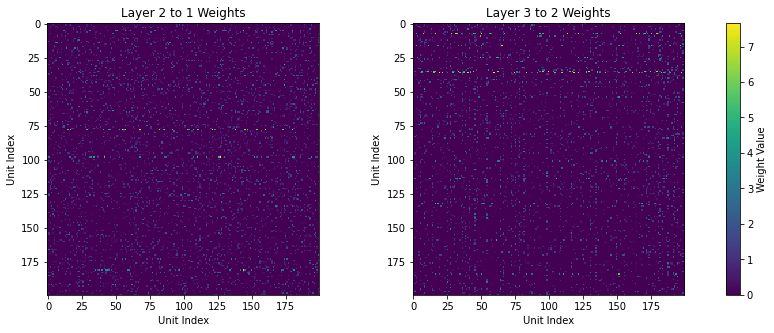

In [91]:
# Assuming data['w21'] and data['w32'] contain the weights arrays for the recurrent connections
weights_layer21 = data['w21']
weights_layer32 = data['w32']

# Determine the overall min and max values of the weights arrays
min_val = min(weights_layer1.min(), weights_layer2.min(), weights_layer3.min())
max_val = max(weights_layer1.max(), weights_layer2.max(), weights_layer3.max())

# Create subplots for each layer
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot heatmap for layer 1
axes[0].imshow(weights_layer21, cmap='viridis', interpolation='nearest')
axes[0].set_title('Layer 2 to 1 Weights')
axes[0].set_xlabel('Unit Index')
axes[0].set_ylabel('Unit Index')
axes[0].set_aspect('equal')  # Set aspect ratio to be equal

# Plot heatmap for layer 2
heatmap2 = axes[1].imshow(weights_layer32, cmap='viridis', interpolation='nearest', vmin=min_val, vmax=max_val)
axes[1].imshow(weights_layer32, cmap='viridis', interpolation='nearest')
axes[1].set_title('Layer 3 to 2 Weights')
axes[1].set_xlabel('Unit Index')
axes[1].set_ylabel('Unit Index')
axes[1].set_aspect('equal')  # Set aspect ratio to be equal


# Add colorbars
fig.colorbar(heatmap2, ax=axes.ravel().tolist(), label='Weight Value')

plt.show()

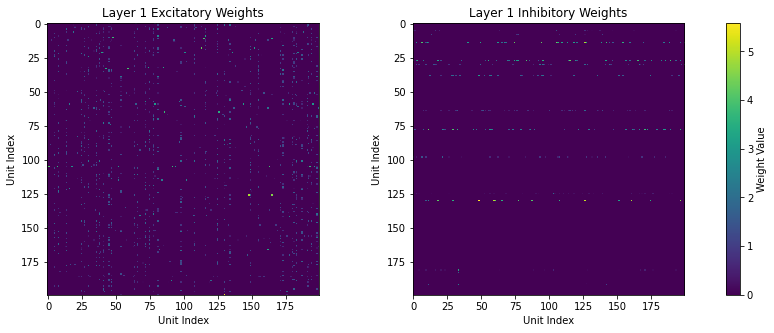

In [133]:
# Look at weights excitatory versus inhibitory units
# For now just looking at layer 1 - don't know if it makes sense to combine across layers
# Assuming data['w1'], data['w2'], and data['w3'] contain the weights arrays for the three layers
Eweights_layer1 = data['w1'] * data['exc1']
Iweights_layer1 = data['w1'] * data['inh1']

# Determine the overall min and max values of the weights arrays
min_val = min(Eweights_layer1.min(), Iweights_layer1.min())
max_val = max(Eweights_layer1.max(), Iweights_layer1.max())

# Create subplots for each layer
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot heatmap for layer 1
axes[0].imshow(Eweights_layer1, cmap='viridis', interpolation='nearest')
axes[0].set_title('Layer 1 Excitatory Weights')
axes[0].set_xlabel('Unit Index')
axes[0].set_ylabel('Unit Index')
axes[0].set_aspect('equal')  # Set aspect ratio to be equal

# Plot heatmap for layer 2
heatmap = axes[1].imshow(Iweights_layer1, cmap='viridis', interpolation='nearest', vmin=min_val, vmax=max_val)
axes[1].imshow(Iweights_layer1, cmap='viridis', interpolation='nearest')
axes[1].set_title('Layer 1 Inhibitory Weights')
axes[1].set_xlabel('Unit Index')
axes[1].set_ylabel('Unit Index')
axes[1].set_aspect('equal')  # Set aspect ratio to be equal


# Add colorbars
fig.colorbar(heatmap, ax=axes.ravel().tolist(), label='Weight Value')

plt.show()

In [ ]:
# Look at decoding excitatory versus inhibitory units - in progress
# Decode trials
# which layer do we want? 
layer = 1

# averge fr over this time window post stimulus
# this is unit of model time-steps
t_win = [ 200,-1 ]

# number of cv folds
n_cvs = 5 # performance goes up with fewer cvs? looked at 3

# store the accuracy
acc = np.full( ( n_cvs ), np.nan )

# penalties to eval
num_cgs = 30
Cs = np.logspace( -5,1,num_cgs )

# set up the grid
param_grid = { 'C': Cs, 'kernel': ['linear'] }

# define object - use a SVC that balances class weights (because they are biased, e.g. 70/30)
# note that can also specify cv folds here, but I'm doing it by hand below in a loop
grid = GridSearchCV( SVC(class_weight = 'balanced'),param_grid,refit=True,verbose=0 )

# get the data from the layer that we want
# this is a [trial x time step x unit] matrix
data_d = locals()[f'fr{layer}']


In [ ]:
# avg over time window - in progress
#data_d = np.mean( data_d[ :,t_win[0]:t_win[1],: ], axis = 1 )

# get some info about structure of the data
tris = data_d.shape[0]             # number of trials
tri_ind = np.arange(0,tris)      # list from 0...tris
hold_out = int( tris / n_cvs )   # how many trials to hold out

decoding_acc = np.zeros((task_info['trial_dur'],))

for t_step in range(task_info['trial_dur']):
    
    data_slice = data_d[:, t_step, :]
    
    # loop over cvs and do classification
    for i in range(n_cvs):

        # trials to hold out as test set on this cv fold
        tst_ind = tri_ind[ i*hold_out : (i+1)*hold_out ]

        # index into the training data on this cv fold
        trn_ind = np.setdiff1d( tri_ind, tst_ind )

        # get the training data (X) and the training labels (y)
        # note that y is unbalanced unless prob is 50/50
        # todo: verify that SVC(class_weight = 'balanced')
        # is working as desired!
        # HK done: follows formula of n/ki
        X = data_slice[trn_ind,:]
        y = labs[trn_ind].flatten()

        # fit the model
        grid.fit( X,y )

        # progress report
        #print(f'CV: {i}, {grid.best_estimator_}')

        # get the test data (X) and the test labels (y)
        X_test = data_slice[tst_ind, :]
        y_test = labs[tst_ind]

        # predict!
        acc[ i ] = grid.score( X_test,y_test )

    decoding_acc[t_step] = np.mean(acc)
print(f'done decoding')

In [ ]:
# Plot decoding accuracy over time - in progress
plt.figure()
plt.plot(range(task_info['trial_dur']), decoding_acc)
plt.xlabel('Time Step')
plt.ylabel('Decoding Accuracy')
plt.title('Decoding Accuracy Over Time')
plt.axvspan(task_info['stim_on'], task_info['stim_on']+task_info['stim_dur'], color = 'gray', alpha = 0.3)
plt.show()